In [1]:
import os 
os.chdir("F://buffalo//buffalo project//netflix")

In [2]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [3]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    
    data = open('data.csv', mode='w')
    
    row = list()
    files=['combined_data_2.txt', 
           'combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] 
                line = line.strip()
                if line.endswith(':'):
                    # 
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.001001


In [4]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',',names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# ordering rating based on time 
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [5]:
df.head()

,movie,user,rating,date
49557332,17064,510180,2,1999-11-11
46370047,16465,510180,3,1999-11-11
22463125,8357,510180,4,1999-11-11
35237815,14660,510180,2,1999-11-11
21262258,8079,510180,2,1999-11-11


## checking for missing values

In [7]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


## checking stats of the data 


In [8]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 53825114
Total No of Users   : 478723
Total No of movies  : 9114


## splittting data

In [9]:
if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

## train data details

In [12]:
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

SyntaxError: unexpected EOF while parsing (<ipython-input-12-82673ba9325c>, line 5)

## Test data details

In [ ]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

## EDA

In [12]:
# for Y label 

def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<IPython.core.display.Javascript object>


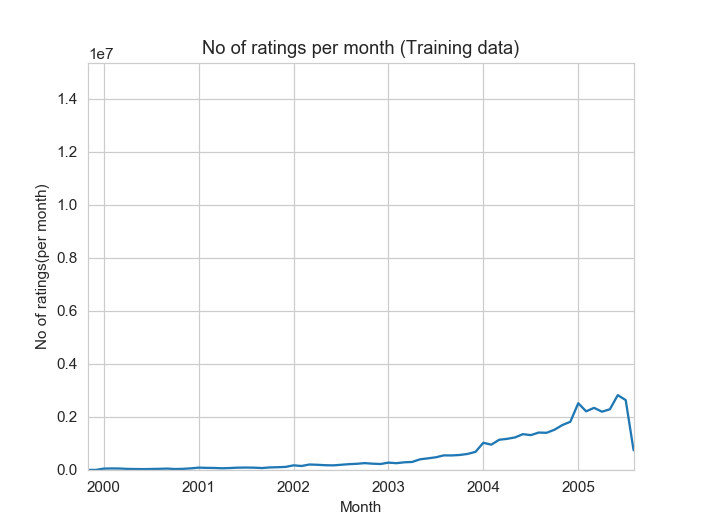

<IPython.core.display.Javascript object>


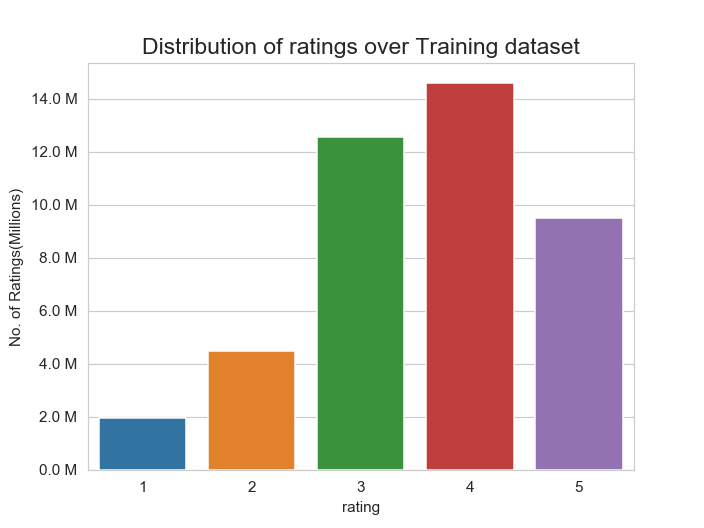

In [13]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

## number of rating per month



In [20]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.weekday_name

train_df.tail()

,movie,user,rating,date,day_of_week
43060086,8370,2570992,3,2005-08-09,Tuesday
43060087,17324,60769,4,2005-08-09,Tuesday
43060088,17174,1831297,4,2005-08-09,Tuesday
43060089,5765,1779412,4,2005-08-09,Tuesday
43060090,16922,1367773,5,2005-08-09,Tuesday


<IPython.core.display.Javascript object>


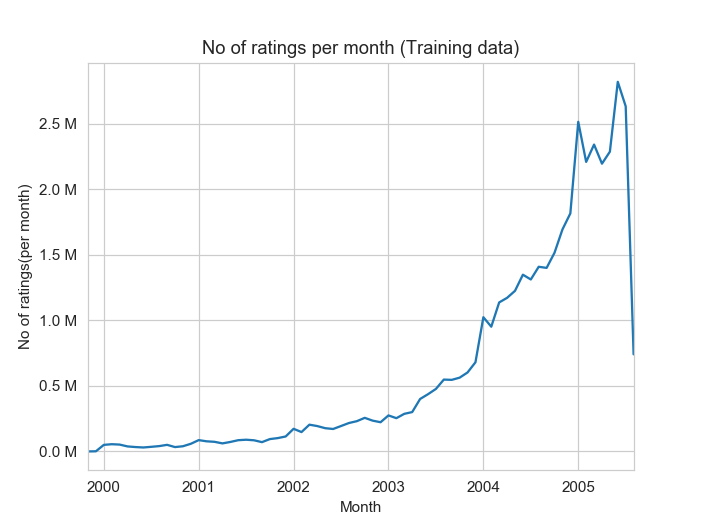

In [14]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

## rating per user

In [15]:

no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     8779
2439493    8126
387418     7884
1639792    4983
1461435    4846
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


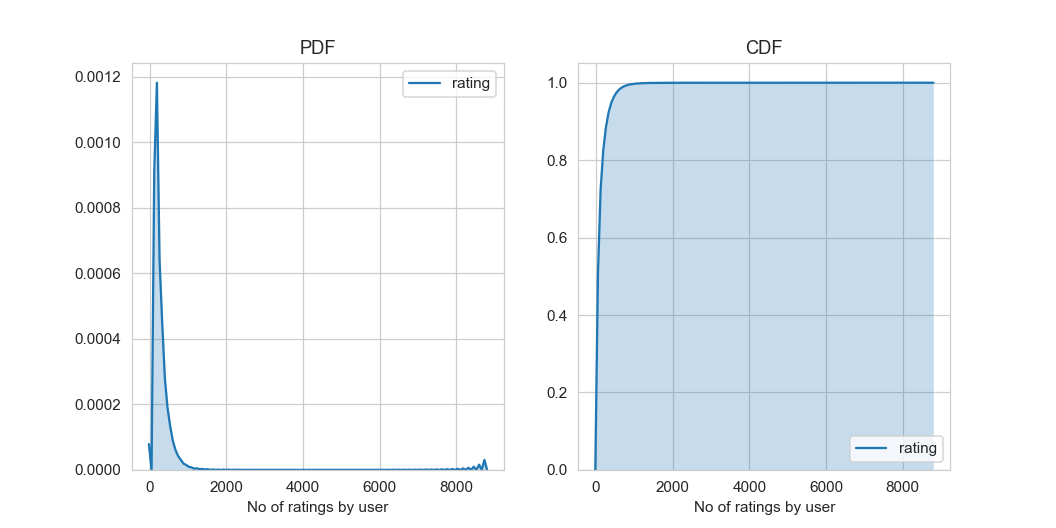

In [21]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

## rating per user

<IPython.core.display.Javascript object>


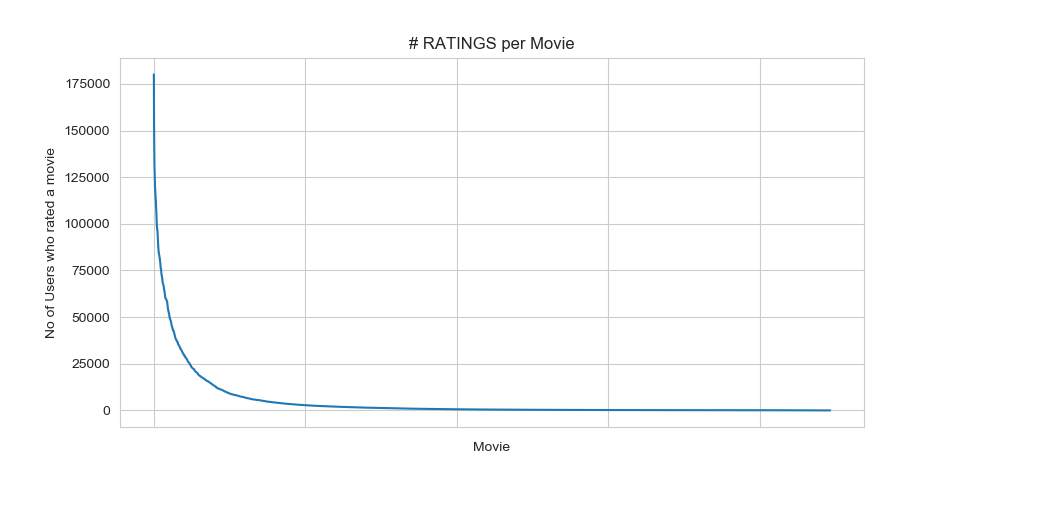

In [17]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

<IPython.core.display.Javascript object>


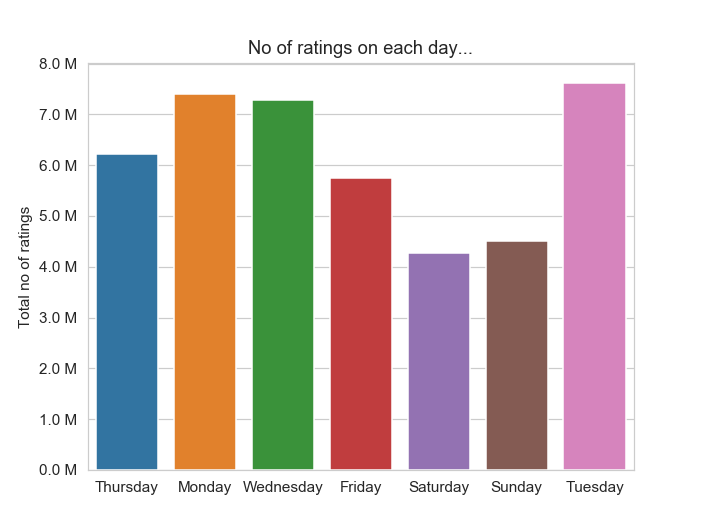

In [22]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [23]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.589555
Monday       3.577235
Saturday     3.595120
Sunday       3.596637
Thursday     3.583570
Tuesday      3.574852
Wednesday    3.585002
Name: rating, dtype: float64




## sparse matrix from data frame


In [24]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    
    
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE..")
else: 
    
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)


Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:04:07.847667


## sparsity level of the matrix

In [25]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.90854433187319 % 


## same for test


In [26]:
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")

    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE..")
else: 
    
    
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
   
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:00:19.334181


## sparsity for test level

In [27]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.97713608243731 % 
